# Baseline Model for Crop Yield Estimation and Explaining the Relevant Factors for Model Decisions
The goal in this hackaton is to use the knowledge about explainable AI gathered in the ML4Earth xAI workshop to build machine learning model for yield prediction and to use explainable machine learning to identify the relevant factors and discover the impact of the extreme weather events for crop yield prediction [1]. Crop yield estimation is extremely important for ensuring food security in terms of the ever increasing extreme weather events [2]. Therefore, having an accurate model for yield prediction and at the same time being able to explain the relevant factors which drive the model inference is essential for designing efficient agricultural policies which can help to mitigate the food security challenges.

In this notebook, we provide an example of how to train a baseline random forest model and to use the SHAP method [3] to understand the driving factors for the model predictions.

First, we import the libraries necessary for bulding the random forest model and the explainability analysis.

In [168]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import json
import csv as csv
from osgeo import gdal,gdalconst, gdal_array
from osgeo import ogr,osr
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
from PIL import Image, ImageDraw
import glob

import rasterio as rio;
import rasterio.mask;

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import codecs
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

(13, 69, 93)


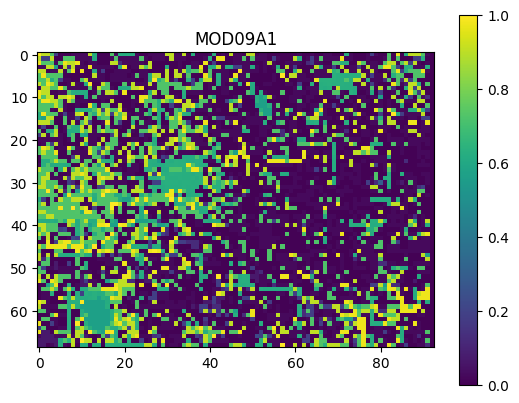

In [153]:
filepath = "/Users/siruiwang/ML4Earth-Hackathon-2022-main/dataset/composite_npy/image_tif/2021/20210813_18099.tif"
filepath1 = "/Users/siruiwang/ML4Earth-Hackathon-2022-main/dataset/composite_npy/image_tif/2021"
Ground_truth = "/Users/siruiwang/ML4Earth-Hackathon-2022-main/dataset/composite_npy/Ground_truth/corn_2021.tif"
Ground_truth_history = "/Users/siruiwang/ML4Earth-Hackathon-2022-main/dataset/composite_npy/Ground_truth/corn_2020.tif"
solfie = glob.glob(filepath+ '/*.tif',  recursive=True)
file_names = [x.split('/')[-1].replace('.tif', '') for x in solfie]
date = np.array([x[:8] for x in file_names])
geoids = np.array([x.split('_')[-1] for x in file_names])
file_pairs = list(set(zip(geoids, date))) # keep only unique pairs

# read images


  # Open the file:
raster = gdal.Open(filepath)
  #dataset = np.array(raster)
  # Check type of the variable 'raster'
type(raster)
  # Projection
raster.GetProjection()
  # Dimensions
RX=raster.RasterXSize
RY=raster.RasterYSize
  # Number of bands
band_count = raster.RasterCount  
  # Metadata for the raster dataset
raster.GetMetadata()
band=[]
  # Read the raster band as separate variable
for index in range(1, band_count+1):
        # reading band
        #print("reading" + str(index) + "band")
    band_index= raster.GetRasterBand(index).ReadAsArray(buf_xsize=raster.RasterXSize, buf_ysize= raster.RasterYSize)
    band.append(band_index)
bands=np.array(band)

    #print(raster.RasterCount, raster.RasterXSize, raster.RasterYSize)
print(bands.shape)


  
    
dataset=[]
#dataset.append(bands,axis=1)
#datasets=np.array(dataset)
#print(datasets.shape)
def norm_img(X):        
    return ((X - np.min(X)) / (np.max(X) - np.min(X)))
    
plt.imshow(norm_img(bands[0,:]))
plt.colorbar()
plt.title('MOD09A1')
plt.show()

In [154]:
adfGeoTransform=raster.GetGeoTransform()
#left-top geoinformation
print(adfGeoTransform[0])

print(adfGeoTransform[3])

nXsize= raster.RasterXSize
nYsize= raster.RasterYSize

altitude = np.zeros((RY,RX))
longitude = np.zeros((RY,RX))

for i in range(nYsize):
    #row=[]
    for j in range(nXsize):
        px=adfGeoTransform[0] + i * adfGeoTransform[1] + j * adfGeoTransform[2]
        py=adfGeoTransform[3] + i * adfGeoTransform[4] + j * adfGeoTransform[5]
        col=[px,py]
        #row.append(col)
        #arrSlope.append(col)
        altitude[i,j]=px
        longitude[i,j]=py

#print(np.array(arrSlope).shape)
print(altitude[RY-1,RX-1])
print(longitude[RY-1,RX-1])


-86.46733767292454
41.479708244218905
-86.16191047632391
41.066483213523924


In [155]:
#image resampling

def resampling(source_file, target_file, xRes=RX, yRes=RY):
    
    dataset = gdal.Open(source_file, gdalconst.GA_ReadOnly)
    band_count = dataset.RasterCount  # 波段数

    cols = xRes
    rows = yRes

    geotrans = list(dataset.GetGeoTransform())
    print(dataset.GetGeoTransform())
    print(geotrans)
    geotrans[1] = adfGeoTransform[1]  
    geotrans[5] = adfGeoTransform[5] 

    if os.path.exists(target_file) and os.path.isfile(target_file):  # 如果已存在同名影像
        os.remove(target_file)  # 则删除之

    band1 = dataset.GetRasterBand(1)
    data_type = band1.DataType
    target = dataset.GetDriver().Create(target_file, xsize=cols, ysize=rows, bands=band_count,
                                        eType=data_type)
    target.SetProjection(dataset.GetProjection())  # 设置投影坐标
    target.SetGeoTransform(geotrans)  # 设置地理变换参数
    total = band_count + 1
    for index in range(1, total):
        # 读取波段数据
        print("writing" + str(index) + "band")
        data = dataset.GetRasterBand(index).ReadAsArray(buf_xsize=cols, buf_ysize=rows)
        out_band = target.GetRasterBand(index)
        out_band.SetNoDataValue(dataset.GetRasterBand(index).GetNoDataValue())
        out_band.WriteArray(data)  # 写入数据到新影像中
        out_band.FlushCache()
        out_band.ComputeBandStats(False)  # 计算统计信息
    print("done")
    del dataset
    del target

In [156]:
#convert tif image to shp boundary
inband = raster.GetRasterBand(1)  #这个波段就是最后想要转为矢量的波段，如果是单波段数据的话那就都是1
prj = osr.SpatialReference()  
prj.ImportFromWkt(raster.GetProjection())   #读取栅格数据的投影信息，用来为后面生成的矢量做准备
    
outshp = filepath[:-4] + ".shp" #给后面生成的矢量准备一个输出文件名，这里就是把原栅格的文件名后缀名改成shp了
drv = ogr.GetDriverByName("ESRI Shapefile")
if os.path.exists(outshp):  #若文件已经存在，则删除它继续重新做一遍
    drv.DeleteDataSource(outshp)
Polygon = drv.CreateDataSource(outshp)  #创建一个目标文件
Poly_layer = Polygon.CreateLayer(filepath[:-4], srs = prj, geom_type = ogr.wkbPolygon)#wkbMultiPolygon) #对shp文件创建一个图层，定义为多个面类
newField = ogr.FieldDefn('')#'value')#,ogr.OFTReal)  #给目标shp文件添加一个字段，用来存储原始栅格的pixel value
Poly_layer.CreateField(newField)

gdal.FPolygonize(inband, None, Poly_layer, 0) #核心函数，执行的就是栅格转矢量操作
Polygon.SyncToDisk() 
Polygon = None

In [157]:
Ground_truth_wrap =  filepath[:-4] + "_GT.tif" 
Ground_truth_wrap_history =  filepath[:-4] + "_GTH.tif" 

OutTile = gdal.Warp(Ground_truth_wrap, Ground_truth, format='GTiff', cutlineDSName=outshp, cropToCutline=True, dstNodata=-9999)
OutTile = gdal.Warp(Ground_truth_wrap_history, Ground_truth_history, format='GTiff', cutlineDSName=outshp, cropToCutline=True, dstNodata=-9999)
OutTile = None


In [158]:
Ground_truth_wrap_resample =  filepath[:-4] + "_GTR.tif" 
resampling(Ground_truth_wrap, Ground_truth_wrap_resample,xRes=RX, yRes=RY)
Ground_truth_wrap_history_resample =  filepath[:-4] + "_GTRH.tif" 
resampling(Ground_truth_wrap_history, Ground_truth_wrap_history_resample,xRes=RX, yRes=RY)



(-86.46451400000001, 0.0030000000000001137, 0.0, 41.479298, 0.0, -0.0029999999999999758)
[-86.46451400000001, 0.0030000000000001137, 0.0, 41.479298, 0.0, -0.0029999999999999758]
writing1band
done
(-86.46451400000001, 0.0030000000000001137, 0.0, 41.479298, 0.0, -0.0029999999999999758)
[-86.46451400000001, 0.0030000000000001137, 0.0, 41.479298, 0.0, -0.0029999999999999758]
writing1band
done


In [159]:
# Open the file:
gthraster = gdal.Open(Ground_truth_wrap_history_resample)
band_i= gthraster.GetRasterBand(1).ReadAsArray(buf_xsize=gthraster.RasterXSize, buf_ysize= gthraster.RasterYSize)
history_array=np.array([band_i])
features=np.append(bands,history_array,axis=0)
print(features.shape)

gtraster = gdal.Open(Ground_truth_wrap_resample)
band_ii= gtraster.GetRasterBand(1).ReadAsArray(buf_xsize=gtraster.RasterXSize, buf_ysize= gtraster.RasterYSize)
yield_array=np.array([band_ii])
print(yield_array.shape)


(14, 69, 93)
(1, 69, 93)


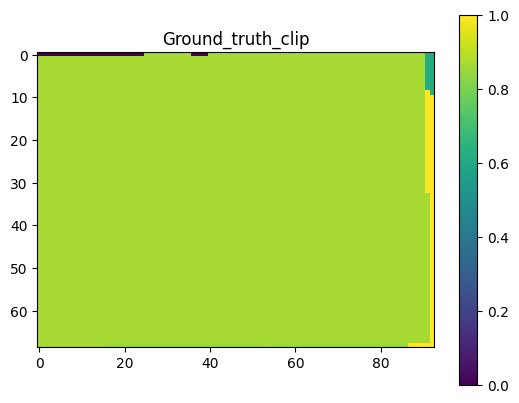

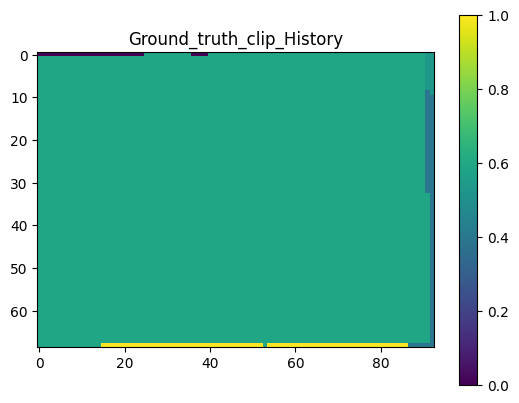

In [162]:
# Open the file:
GTraster = gdal.Open(Ground_truth_wrap_resample)
# Read the raster band as separate variable
band_1_gt = GTraster.GetRasterBand(1)
Ground_truth_clip = band_1_gt.ReadAsArray()
plt.imshow(norm_img(Ground_truth_clip))
plt.colorbar()
plt.title('Ground_truth_clip')
plt.show()
# Open the file:
GTHraster = gdal.Open(Ground_truth_wrap_history_resample)
# Read the raster band as separate variable
band_1_gtH = GTHraster.GetRasterBand(1)
Ground_truth_clip_H = band_1_gtH.ReadAsArray()
plt.imshow(norm_img(Ground_truth_clip_H))

plt.colorbar()
plt.title('Ground_truth_clip_History')
plt.show()


In [ ]:
# Random forest regressor needs a vector as input
#train and test the random forest model based on the data acquired in 2021
_shape = features.shape

features_vector=np.reshape(features, (_shape[0], _shape[1] * _shape[2] ))
print(features_vector.shape)
_shape = yield_array.shape
yield_vector=np.reshape(yield_array, (_shape[0], _shape[1] * _shape[2] ))
counties_features_train, counties_features_test, counties_yield_train, counties_yield_test = train_test_split(features_vector, yield_vector, test_size=0.2, random_state=42)



In [ ]:
# The details of the RandomForestRegressor can be found at https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
rf_base = RandomForestRegressor(random_state=3108)

rf_base.fit(counties_features_train, counties_yield_train)
pop_pred_rf = rf_base.predict(counties_features_test)

In [ ]:
mae_base = mean_absolute_error(counties_yield_test, pop_pred_rf)
rmse_base = mean_squared_error(counties_yield_test, pop_pred_rf, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_base = r2_score(counties_yield_test, pop_pred_rf)

print("MAE:", mae_base) # Best possible is 0
print("RMSE:", rmse_base) # Best possible is 0
print("R2:", r2_base) # Best possible is 1

In [ ]:
print("Total population in test set:", np.sum(counties_yield_test))
print("Total population predicted:", int(np.sum(pop_pred_rf)))

print("Average population per sample in test set:", np.average(counties_yield_test))
print("Average population per sample in predicted set:", np.average(pop_pred_rf))

lim = int(np.min( [np.max(counties_yield_test), np.max(pop_pred_rf)]))

plt.scatter(counties_yield_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Crop yield")
plt.ylabel("Predicted yield count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

In [ ]:
simple_nn = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1], _shape[2], _shape[3])),
  tf.keras.layers.Dense(128, activation='relu'),  
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1),
])

simple_nn.compile(optimizer='adam',
              loss='mean_absolute_error')
print(_shape[1], _shape[2], _shape[3])


In [ ]:
simple_nn.fit(counties_features_train, counties_yield_train, epochs=5)
pop_pred_nn = simple_nn.predict(counties_features_test)

In [ ]:
mae_nn = mean_absolute_error(counties_yield_test, pop_pred_nn)
rmse_nn = mean_squared_error(counties_yield_test, pop_pred_nn, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn = r2_score(counties_yield_test, pop_pred_nn)

print("MAE:", mae_nn) # Best possible is 0
print("RMSE:", rmse_nn) # Best possible is 0
print("R2:", r2_nn) # Best possible is 1

In [ ]:
lim = int(np.max( [lim, np.max(pop_pred_nn)]))

plt.scatter(counties_yield_test, pop_pred_nn, label="NN", color="blue")
plt.scatter(counties_yield_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Crop yield")
plt.ylabel("Predicted yield count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()